# Objetivo: Note base que implementa funciones para script procesador de productos
# Autor: Gustavo V. Diaz
# Fecha: 22/09/2024
# Fecha última modif: 15/12/2024

### Descripción
Script base que servirá para copiar y pegar esctructura general y funciones desarrolladas en módulo especializado para las tareas necesarias.

Se parte de la hipótesis de tener definido un dataframe que contenga la búsqueda realizada por "searcher_filt.py" junto con el kml de búsqueda inicial. Posteriormente se irá recorriendo el dataframe para:
1. Primera parte
    1. ~Lectura de configuración para procesador ('CONF_PROC.INI)~<sup>1</sup>
    2. ~Si me encuentro desarrollando borrar carpeta root cuando reinicio procesamiento~
    2. ~Crear carpeta root ('proj_name' + fecha y hora de procesamiento)~
    3. ~Crear subcarpeta cutted_masked (para guardar productos dim cortados y enmascarados)~
    4. ~Crear subcarpeta table (para tabla de procesamientos en csv)~
    5. ~Crear subcarpeta tmp (para procesar producto que bajo)~
    5. ~Lectura de csv definido en campo prods_list de archivo de configuración conf_dict['FOLDERS']['prods_list']~
    1. ~Bajar producto~
    3. ~Ingresar polígono de búsqueda a snappy~
    2. ~Recortarlo~
    4. Aplicar resize a producto SNAP
    5. Enmascarar cirros
    6. Enmascarar por ROI de búsqueda
    7. Guardar producto procesado en carpeta cutted_masked y registrar path de dicho producto en df de procesamiento
    8. Cuando se procesan todos guardar dataframe de procesamiento en carpeta table
2. Segunda parte
    1. Leer procesamiento a realizar en configuración (NDVI o RGB por el momento)
    2. Crear carpeta de producto procesados, por ejemplo: NDVI o RGB
    2. Procesar productos según la configuración del procesador
    3. Registrar valor medio y desvío de coeficiente o en caso de RGB media de la suma de las tres bandas en dataframe de procesamiento
    4. Guardar muestra de producto, por ejemplo si la configuración es NDVI guardar producto generado en carpeta NDVI
3. Tercera parte
    1. Generar gráfico de serie temporal de productos.

<sup>1</sup> configuración generada en función save_conf2proc de módulo mod_search_filt en carpeta utils. La función tiene como entrada el archivo de configuración inicial 'CONF_SEARCHER.INI'.

#### Entradas
1. Lectura configuración de procesador, define lo siguiente:
    1. Listado de productos seleccionados
    2. Ruta a archivo kml de entrada
    3. wkt de kml de entrada
    4. Carpeta de salida
    5. Usuario de Copernicus Dataspace
    6. Pass de usuario
    7. Nombre de proyecto
    8. Tipo de procesamiento requerido

#### Salida

1. Carpeta de salida (**nombre de proyecto más fecha de búsqueda**)
    1. Tiff producto procesado (**cutted_masked**)
        1. Tiff (georreferenciado)
        1. png (quicklook)
    2. Tabla con path y valores (**Proc_table**)
        1. Productos
            1. Id
            2. acq_date
            3. Tiff_Prod_name (salida)
            4. Ruta a Tiff_Prod_name
        2. Configuración
            1. Configuración de búsqueda
            2. Cantidad de productos procesados
            3. Fecha inicio análisis
            4. Fecha fin análisis
            5. Fecha procesamiento
            6. Nombre ROI
    3. Productos recortados y enmascarados (**cutted_masked**)
        1. Productos en formato .dim (snap)
    4. Gráfico de serie (**Plot**)
        1. Gráfico temporal de tabla con coeficiente de procesamiento ordenado en fecha.


In [1]:
# Declaración de módulos necesarios
# Para lectura de csv
import pandas as pd
import sys
import os
import configparser
import shutil

# módulo para verificar si un path existe
from pathlib import Path

# Módulo para bajer productos S2
sys.path.append(r'../utils')
import mod_dloader as mdl
# Para implementar funciones de snappy en módulo
import mod_snappy_S2 as msnap

# Módulos para desarrollar función que muestra atributos de S2
import snappy
from snappy import ProductIO
from snappy import WKTReader
# Para implementar subset
from snappy import HashMap
from snappy import GPF

# sys.path.append(r'../utils')
# import mod_search_filt as msf

# Declaración de variables para configuración
# input_path = r'/src/output/research_20240928T190500_Tratayen.csv'
# input_path_pkl = r'/src/output/research_20240928T190500_Tratayen.pkl'
verbose = True
# kml_path = r'/src/Vectores/Tratayen.kml'

# Lectura de configurador de procesador
# Script para generar request de búsqueda y filtrado de productos Sentinel-2

# import mod_search_filt as msf

/opt/venv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Creación o lectura de archivo de configuración
def read_conf_proc(path2conf, verbose):
    if not(os.path.exists(path2conf)):
        create_conf_file_proc(path2conf)
    if verbose:
        with open(path2conf, 'r') as file:
            # Read the content of the file
            file_content = file.read()
            # Print the content
            print("File Content:\n", file_content)
    conf2dict = configparser.ConfigParser()
    with open(path2conf,"r") as file:
        conf2dict.read_file(file)
    # conf2dict.read_file(path2conf)
    return {s:dict(conf2dict.items(s)) for s in conf2dict.sections()}

def create_conf_file_proc(path2conf):
    # Configuración inicial
    # ROI*
    # Fecha de inicio de búsqueda
    # Fecha de fin de búsqueda
    # Tipo de producto Sentinel
    # Porcentaje de nubosidad límite
    # Nombre de proyecto relacionado
    dict_gen = {
        'FOLDERS': {
            ';Prueba de comentarios para FOLDERS':None,
            'ROI': r'/src/Vectores/',
            'OUTPUT': '/src/Output/'
        },
        'ATTRIB': {
            ';Prueba de comentarios para ATTRIB':None,
            'init_date':'01-01-2019',
            'final_date':'31-01-2021',
            'max_cloud':'50',
            'Sent_mission':'MSIL2A',
            'proj_name':'Your name'
        },
        'ESA_SERVER': {
            ';Prueba de comentarios para ESA_SERVER':None,
            'url':'https://catalogue.dataspace.copernicus.eu/odata/v1/Products',
            'orderby': 'ContentDate/Start',
            'top':'100'
    },
        'SCRIPTING':{
            ';Configuración para aplicar en funciones':None,
            'verbose': False
        }
    }
    with open(path2conf,"w") as file:
    # file =open("employee1.ini","w")
        config_object = configparser.ConfigParser(allow_no_value=True)
    # myDict={'employee': {'name': 'John Doe', 'age': '35'},
    #         'job': {'title': 'Software Engineer', 'department': 'IT', 'years_of_experience': '10'},
    #         'address': {'street': '123 Main St.', 'city': 'San Francisco', 'state': 'CA', 'zip': '94102'}}
        sections=dict_gen.keys()
        for section in sections:
            config_object.add_section(section)
        for section in sections:
            inner_dict=dict_gen[section]
            fields=inner_dict.keys()
            for field in fields:
                value=inner_dict[field]
                config_object.set(section, field, str(value))
        config_object.write(file)
    # file.close()
    return None

In [3]:
# Definición de funciones a resolver
# Limpieza de carpeta generada (normalmente va a estar completa en etapa de debbuging.
def del_folder(path2folder, verbose):
    # Creo la variable root_folder para definir la carpeta base a borrar
    root_folder = Path(path2folder)
    # Verifico si existe la carpeta
    if root_folder.exists():
        shutil.rmtree(path2folder)
    if verbose:
        print(f'The folder {root_folder} has been deleted.')
    return None

def folder_creator(root_path, folder2create, verbose):
    # Creo la variable root_folder para definir la carpeta base sobre la cual se crearán las subcarpetas del proyecto.
    root_folder = Path(root_path)
    if root_folder.exists():
        folder_list = [root_folder, folder2create]
        path2newfol = Path(*folder_list)
        path2newfol.mkdir()
    else:
        sys.exit(f'Función "{folder_creator.__name__()}" terminada porque no se encontró la ruta a la carpeta "{root_path}" donde debe crearse "{folder2create}"')
    if verbose:
        print(f'Creación correcta de carpeta "{path2newfol}"')
    return path2newfol

# Lectura de dataframes de búsqueda a partir del csv

def lectura_csv(path, verbose):
    df = pd.read_csv(path)
    if verbose:
        print(f'Muestro variable path de función {lectura_csv.__name__}')
        print()
        display(df)
    return df

def lectura_pkl(path, verbose):
    df = pd.read_pickle(path)
    if verbose:
        print(f'Muestro variable path de función {lectura_csv.__name__}')
        print()
        display(df)
    return df

In [4]:
# Cuerpo de script a ejecutar
# Parte 1ra
# Tengo definido ruta a archivo de configación del procesador general.
config_path = r'/src/utils/CONF_PROC.INI'
development = True

verbose2conf = False

# Función 1A
# Lectura de archivo de configuración de búsqueda
conf_dict = read_conf_proc(config_path, verbose2conf)

# Función 1B
# Borrado de carpeta root en caso de que se haya creado algo.
root_folder = Path(conf_dict['FOLDERS']['output'])
if development:
    del_folder(root_folder, True)

# Función 1C
# Creación de carpeta root para salida de procesamiento
root_folder.mkdir()
# os.makedirs(root_folder)

# Función 1D
# Creación de carpeta cutted_masked partiendo de root_folder
subfolder_name = 'cutted_masked'
cutted_masked_path = folder_creator(root_folder, subfolder_name, True)

# Función 1E
# Creación de carpeta table (carpeta donde guardaré df de salida)
subfolder_name = 'table'
table_path = folder_creator(root_folder, subfolder_name, True)

# Función 1F
# Creación de carpeta temporal (se guardará producto S2 y se procesará, en caso de que necesite guardar algún subproducto)
subfolder_name = 'tmp'
tmp_path = folder_creator(root_folder, subfolder_name, True)

# Función 1G
# Lectura de csv con listado de productos
path2csv = conf_dict['FOLDERS']['prods_list']
df = lectura_csv(path2csv, verbose)

display(conf_dict)

# Reescribo variables a partir de conf_dict recién escrito
# input_path = r'/src/output/research_20240928T190500_Tratayen.csv'
# print(input_path, conf_dict['FOLDERS']['prods_list'], sep='\n')
# input_path_pkl = r'/src/output/research_20240928T190500_Tratayen.pkl'
# print(input_path_pkl, conf_dict['FOLDERS']['prods_list'])
# verbose = True
# kml_path = r'/src/Vectores/Tratayen.kml'
# print(kml_path, conf_dict['FOLDERS']['kml_input'], sep='\n')

The folder /src/Output/Del_Ru_20241013T182330 has been deleted.
Creación correcta de carpeta "/src/Output/Del_Ru_20241013T182330/cutted_masked"
Creación correcta de carpeta "/src/Output/Del_Ru_20241013T182330/table"
Creación correcta de carpeta "/src/Output/Del_Ru_20241013T182330/tmp"
Muestro variable path de función lectura_csv



,Unnamed: 0,Unnamed: 1,Unnamed: 2,cloudCover,Id,Name,shape,acq_date
0,MSIL2A,T19HET,N0500,0.000814,e40a9085-4a16-455d-8377-e3c2312715a0,S2B_MSIL2A_20190101T142749_N0500_R053_T19HET_2...,"POLYGON ((-68.30426 -37.9438950788142, -69.000...",2019-01-01 14:27:49
1,MSIL2A,T19HET,N0500,0.001022,33ace38d-face-4102-80bd-e96a317e0b65,S2A_MSIL2A_20190103T142031_N0500_R010_T19HET_2...,"POLYGON ((-69.00021 -37.9475895719933, -69.000...",2019-01-03 14:20:31
2,MSIL2A,T19HET,N0500,0.005958,59b95426-0954-4f64-b1ed-54e57d292968,S2A_MSIL2A_20190106T142751_N0500_R053_T19HET_2...,"POLYGON ((-68.3018387005815 -37.9438822102367,...",2019-01-06 14:27:51
3,MSIL2A,T19HET,N0500,10.632945,97053e98-bead-49f0-97b3-6a7f31658ef6,S2B_MSIL2A_20190111T142749_N0500_R053_T19HET_2...,"POLYGON ((-68.302826 -37.9438874394396, -69.00...",2019-01-11 14:27:49
4,MSIL2A,T19HET,N0500,45.648462,1286e151-82b3-4798-a0ff-d573bb796321,S2A_MSIL2A_20190116T142751_N0500_R053_T19HET_2...,"POLYGON ((-68.30081 -37.9438767283094, -69.000...",2019-01-16 14:27:51
5,MSIL2A,T19HET,N0500,0.002797,0e23779d-5aef-4e62-8c17-e2947f6d299c,S2B_MSIL2A_20190118T142039_N0500_R010_T19HET_2...,"POLYGON ((-69.00021 -37.9475895719933, -69.000...",2019-01-18 14:20:39
6,MSIL2A,T19HET,N0500,1.629408,19697b78-2cf9-44a0-871e-d185ac36ac01,S2B_MSIL2A_20190121T142749_N0500_R053_T19HET_2...,"POLYGON ((-68.300934 -37.94387743003, -69.0002...",2019-01-21 14:27:49
7,MSIL2A,T19HET,N0500,0.001924,b30aeb02-e334-4800-a427-a7d821c5cc63,S2A_MSIL2A_20190123T142031_N0500_R010_T19HET_2...,"POLYGON ((-69.00021 -37.9475895719933, -69.000...",2019-01-23 14:20:31
8,MSIL2A,T19HET,N0500,0.001871,4b0ef724-24cf-4b3b-9523-c7dd587d7afe,S2A_MSIL2A_20190126T142751_N0500_R053_T19HET_2...,"POLYGON ((-68.29779 -37.9438607300045, -69.000...",2019-01-26 14:27:51
9,MSIL2A,T19HET,N0500,0.001324,644e18db-f741-4277-a1ed-ba563615870a,S2B_MSIL2A_20190128T142039_N0500_R010_T19HET_2...,"POLYGON ((-69.00021 -37.9475895719933, -69.000...",2019-01-28 14:20:39


{'FOLDERS': {'prods_list': '/src/Output/research_20241013T182330_Tratayen.csv',
  'kml_input': '/src/Vectores/Tratayen.kml',
  'wkt_roi': '/src/Vectores/aux_wkt/wkt_file.txt',
  'output': '/src/Output/Del_Ru_20241013T182330'},
 'ATTRIB': {'user': 'gus838@gmail.com',
  'pass': 'Ul!RsPWTPuw3',
  'proj_name': 'Del_Ru'},
 'PROCESSOR': {'type': 'RGB'}}

In [5]:
# Función 1G
# Bajar productos completos
# Iteración sobre todos los productos
# Dejo una configuración que me permitirá solo procesar el primer producto,\
# cuando verifique que funciona dehabilitaré la función para que procese todos los productos de la misma manera que el primero
flag_one_proc = True

# Definición de usuario
user = conf_dict['ATTRIB']['user']
passw = conf_dict['ATTRIB']['pass']
kc_token = 'KEYCLOAK_TOKEN'

for row in df.iterrows():
    prod_id = row[1]['Id']
    prod_name = row[1]['Name']
    # print(row[1]['Id'])
    # print(row[1]['Name'] + '\n')
    acq_date = row[1]['acq_date']
    str_token = mdl.get_keycloak(user, passw, verbose)
    os.environ[kc_token] = str_token
    print('Variables para generadas en cada iteración:')
    print(f'Id Producto: {prod_id}',f'Nombre producto: {prod_name}',f'user: {user}',f'Key_cloak: {str_token}', sep='\n')
    print(f'Id Producto: {prod_id}',f'\nNombre producto: {prod_name}',f'\nuser: {user}')
    print()
    file2verif = os.path.join(tmp_path,prod_name + '.zip')
    if os.path.isfile(file2verif):
        print(f'Archivo {file2verif} existente')
        pass
    else:
        print(f'Archivo {file2verif} NO existente, bajando')
        mdl.prod_downloader_2(prod_id, os.environ[kc_token], tmp_path, prod_name, verbose)
    
    
    if flag_one_proc == True:
        break
    

Visualización de variables en get_keycloak en módulo mod_dloader.py
{'client_id': 'cdse-public', 'username': 'gus838@gmail.com', 'password': 'Ul!RsPWTPuw3', 'grant_type': 'password'}
Variables para generadas en cada iteración:
Id Producto: e40a9085-4a16-455d-8377-e3c2312715a0
Nombre producto: S2B_MSIL2A_20190101T142749_N0500_R053_T19HET_20221213T151300.SAFE
user: gus838@gmail.com
Key_cloak: eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJYVUh3VWZKaHVDVWo0X3k4ZF8xM0hxWXBYMFdwdDd2anhob2FPLUxzREZFIn0.eyJleHAiOjE3MzQ0NjA2NzcsImlhdCI6MTczNDQ2MDA3NywianRpIjoiMzMyMzlkYTMtNjcwYy00MzI2LWE5NTUtNjkyNTA5ODlhNTMxIiwiaXNzIjoiaHR0cHM6Ly9pZGVudGl0eS5kYXRhc3BhY2UuY29wZXJuaWN1cy5ldS9hdXRoL3JlYWxtcy9DRFNFIiwiYXVkIjpbIkNMT1VERkVSUk9fUFVCTElDIiwiYWNjb3VudCJdLCJzdWIiOiI5NjNiNzVlZC01YWUyLTQzMWQtOGU3Yy0zZDNjYTc4ZDYxNDkiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiJjZHNlLXB1YmxpYyIsInNlc3Npb25fc3RhdGUiOiJhYTNiYTYwMC1mMDlkLTQyYTMtOTY5OC0yNzk2OTAxZWQ2YTAiLCJhbGxvd2VkLW9yaWdpbnMiOlsiaHR0cHM6Ly9sb2NhbGhvc3Q6NDIwMCIsIioiLCJodH

S2B_MSIL2A_20190101T142749_N0500_R053_T19HET_20221213T151300.SAFE.zip: 65.0kit [01:20, 803it/s]                             


In [17]:
# Función para mostrar atributos de productos con entrada de ruta a productos
def show_att_S2(path2prod, verbose = False):
    product = ProductIO.readProduct(path2prod)
    width = product.getSceneRasterWidth()
    height = product.getSceneRasterHeight()
    prod_name = product.getName()
    band_names = product.getBandNames()
    str_band_n = ", ".join(band_names).split(", ")
    # display(len(str_band_n), str_band_n)
    crs_raster = product.getSceneCRS()
    geocod_raster = product.getSceneGeoCoding()
    if verbose:
        print(f"Ancho: {width} px\n")
        print(f"Alto: {height} px\n")
        print(f"Nombre: {prod_name}\n")
        print(f"Cantidad de bandas: {len(str_band_n)}\n")
#         print("Muestras de proyección de producto", type(crs_raster), crs_raster, type(geocod_raster), geocod_raster, sep = '\n')
    return None

def show_att_snapobj(snap_prod, verbose = False):
    width = snap_prod.getSceneRasterWidth()
    height = snap_prod.getSceneRasterHeight()
    prod_name = snap_prod.getName()
    band_names = snap_prod.getBandNames()
    str_band_n = ", ".join(band_names).split(", ")
    # display(len(str_band_n), str_band_n)
    crs_raster = snap_prod.getSceneCRS()
    geocod_raster = snap_prod.getSceneGeoCoding()
    if verbose:
        print(f"Ancho: {width} px\n")
        print(f"Alto: {height} px\n")
        print(f"Nombre: {prod_name}\n")
        print(f"Cantidad de bandas: {len(str_band_n)}\n")
#         print("Muestras de proyección de producto", type(crs_raster), crs_raster, type(geocod_raster), geocod_raster, sep = '\n')
    return None

def subset_prod(path2prod, path2wkt, verbose):
    # Objetivo 2 del día Cortar producto por geometría
    product = ProductIO.readProduct(path2prod)
    SubsetOp = snappy.jpy.get_type('org.esa.snap.core.gpf.common.SubsetOp')
    with open(path2wkt, 'r') as f:
        wkt_orig = f.readline()
    geometry = WKTReader().read(wkt_orig)
    print(geometry)
    HashMap = snappy.jpy.get_type('java.util.HashMap')
    GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()
    parameters = HashMap()
    parameters.put('copyMetadata', True)
    parameters.put('geoRegion', geometry)
    product_subset = GPF.createProduct('Subset', parameters, product)
    
    # Para debuggear
    print('Datos de producto S2 completo')
    show_att_snapobj(product, True)
    print('Datos de producto S2 recortado')
    show_att_snapobj(product_subset, True)
    return product_subset

In [11]:
# Función 1I
# Ingresar polígono de búsqueda a snappy
path2wkt = conf_dict['FOLDERS']['wkt_roi']
path2prod = os.path.join(tmp_path, file2verif)
show_att_S2(path2prod, verbose = True)
display(conf_dict)

Ancho: 10980 px

Alto: 10980 px

Nombre: S2B_MSIL2A_20190101T142749_N0500_R053_T19HET_20221213T151300

Cantidad de bandas: 158



{'FOLDERS': {'prods_list': '/src/Output/research_20241013T182330_Tratayen.csv',
  'kml_input': '/src/Vectores/Tratayen.kml',
  'wkt_roi': '/src/Vectores/aux_wkt/wkt_file.txt',
  'output': '/src/Output/Del_Ru_20241013T182330'},
 'ATTRIB': {'user': 'gus838@gmail.com',
  'pass': 'Ul!RsPWTPuw3',
  'proj_name': 'Del_Ru'},
 'PROCESSOR': {'type': 'RGB'}}

In [18]:
product_subset = subset_prod(path2prod, path2wkt, True)

POLYGON ((-68.5974389987327 -38.4405494769166, -68.5848549279354 -38.4595413423777, -68.5308981309906 -38.4557115385539, -68.5164736486453 -38.4457572914763, -68.5454183508289 -38.4191997221209, -68.5878144507599 -38.4223643154619, -68.5974389987327 -38.4405494769166))
Datos de producto S2 completo
Ancho: 10980 px

Alto: 10980 px

Nombre: S2B_MSIL2A_20190101T142749_N0500_R053_T19HET_20221213T151300

Cantidad de bandas: 158

Datos de producto S2 recortado
Ancho: 706 px

Alto: 446 px

Nombre: Subset_S2B_MSIL2A_20190101T142749_N0500_R053_T19HET_20221213T151300

Cantidad de bandas: 158



706 446
706 446
706 446


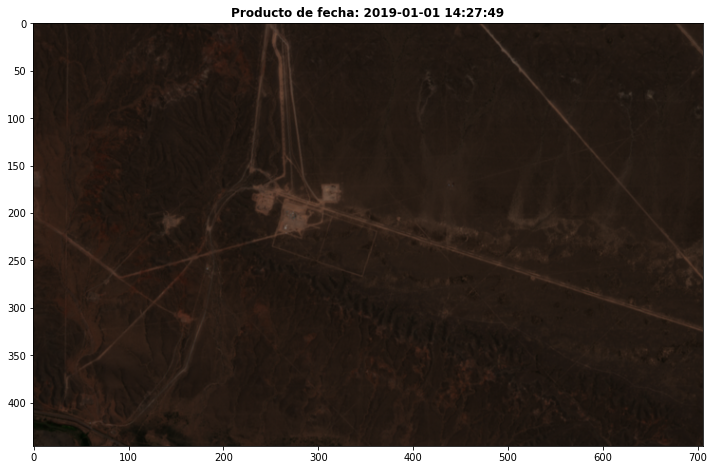

In [19]:
# show_att_snapobj(product_subset, verbose = True)
msnap.plotRGB_s2(product_subset, str(acq_date), 0, 0.3)